### Importing All Necessary Dependencies

In [1]:
import openai
from openai import OpenAI

import numpy as np

import json

import matplotlib.pyplot as plt
from urllib.parse import urlparse
from itertools import combinations

import copy
import math

import requests
import random
import time

from scipy.spatial.distance import cosine
import gensim.downloader as api

from transformers import BertModel, BertTokenizer
import torch

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Establishing Access to OPEN AI API

In [2]:
client = OpenAI(api_key="sk-OPEN_AI_API_KEY")

### Setting up Word2Vec Model for Later Use

In [3]:
word2vec_model = api.load("word2vec-google-news-300")

### Setting up BERT Model for Later Use

In [4]:
model_name = "bert-base-uncased"  
bert_model = BertModel.from_pretrained(model_name)
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

### Function to Convert Image to Large Text Description

*Function*

In [5]:
def image_to_text(image_url):

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": "Please provide a thorough, detailed, and artistic description of the image in the following URL: " + image_url + "Imagine you're painting a vivid picture with words, capturing every detail.",
            }
        ],
        max_tokens=500,
    )
    
    return response.choices[0].message.content

*Testing*

In [11]:
test_description = image_to_text("https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg")

print(test_description)

The scene opens onto a serene slice of nature amidst the bustle of Madison, Wisconsin. A wooden boardwalk, weathered yet sturdy, serves as the pathway inviting us further into this tranquil landscape. It meanders gently, curving toward a distant focal point, flanked by lush, dense tufts of tall, emerald green grass and other verdant plants that crowd close to its edges, almost spilling over onto the walkway.

On this clear day, the sky arches overhead, a vast expanse of an almost surreal, azure blue, speckled sporadically with soft, wispy clouds, whiter than snow. The sunlight is bright but gentle, casting a golden hue across the scene, highlighting the vibrant greens of the vegetation and lending the atmosphere an almost ethereal quality.

To the left of the boardwalk, a body of water lies still, mirroring the sky above with a precision that makes the surface appear more like glass than liquid. The reflections are a mesmerizing mix of blue and the verdant shades from the surrounding f

### Target Pre-defined Labels

*predefined labels list*

In [6]:
predefined_labels_list = {
        'Color Palette': ['Vibrant', 'Monochromatic', 'Pastel', 'Earthy', 'Neon', 'Muted', 'Bold'],
        'Subject Matter': ['Landscape', 'Portrait', 'Still life', 'Abstract', 'Urban', 'Nature', 'Architecture'],
        'Mood/Emotion': ['Serene', 'Energetic', 'Melancholic', 'Joyful', 'Mysterious', 'Peaceful', 'Dramatic'],
        'Style/Aesthetic': ['Realism', 'Impressionism', 'Surrealism', 'Minimalism', 'Expressionism', 'Cubism', 'Romanticism'],
        'Setting/Location': ['Cityscape', 'Countryside', 'Beach', 'Forest', 'Mountains', 'Urban', 'Rural'],
        'Time Period': ['Contemporary', 'Renaissance', 'Medieval', 'Modern', 'Ancient', 'Futuristic', 'Victorian'],
        'Cultural/Symbolic Representation': ['Religious', 'Political', 'Mythological', 'Historical', 'Indigenous', 'Pop culture', 'Folklore']
    }

*creating bert vocab for later use on these predefined labels*

In [7]:
bert_vocab = {}

# Generate BERT embeddings for each label
for attribute, labels in predefined_labels_list.items():
    for label in labels:
        # Tokenize the label
        inputs = bert_tokenizer(label, return_tensors="pt")
        
        # Pass tokenized sequence through BERT model to obtain embeddings
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean pooling of token embeddings
            
        # Store embeddings in bert_vocab dictionary
        bert_vocab[label] = embeddings

In [8]:
# Initialize dictionary to store BERT embeddings for each label
bert_vocab = {}

# Generate BERT embeddings for each label
for attribute, labels in predefined_labels_list.items():
    
    # tokenizing all the labels in labels list and passing them all together into BERT
    inputs = bert_tokenizer(labels, return_tensors="pt", padding=True, truncation=True)

    # Pass tokenized sequence through BERT model to obtain embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
        # map each label to its corresponding embeddings in the output
        for i, label in enumerate(labels):
            embeddings = outputs.last_hidden_state[i].mean(dim=0).numpy()
            bert_vocab[label] = embeddings


*testing bert vocab*

In [41]:
print(bert_vocab['Vibrant'].shape)
print(bert_vocab['Landscape'].shape)
print(bert_vocab['Melancholic'].shape)
print(bert_vocab['Cubism'].shape)
print(bert_vocab['Cityscape'].shape)
print(bert_vocab['Ancient'].shape)
print(bert_vocab['Religious'].shape)

(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)


### Function to Convert Description of Image to Pre-Defined Labels

*Method to Troubleshoot Creation of non pre-defined labels when converting description to labels list*

In [9]:
def validate_attributes(attributes_dict, predefined_list):

    validated_attributes = {}

    for key, values in attributes_dict.items():
        valid_values = [value for value in values if value in predefined_list[key]]
        
        if len(valid_values) < len(values):
            missing_values = [value for value in predefined_list[key] if value not in valid_values]
            valid_values.extend(missing_values[:len(values)-len(valid_values)])
        
        validated_attributes[key] = valid_values
    
    return validated_attributes


*Method to convert description of an image to ordered predefined labels*

In [11]:
def description_to_all_attributes(description, predefined_input_list):

    predefined_list = copy.deepcopy(predefined_input_list)

    response = client.chat.completions.create(
        model = "gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": f"""
                You are a machine learning model trained to extract specific attributes from a detailed 
                description of an image. Your task is to identify and select the most appropriate label from 
                the following pre-defined set of attributes for each of the seven categories given below, and
                represent them as key-value pairs in a Python dictionary: 

                1. Color Palette: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Color Palette']}. 

                2. Subject Matter: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Subject Matter']}. 

                3. Mood/Emotion: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Mood/Emotion']}. 

                4. Style/Aesthetic: Select exactly 7 labels without repetition from ONLY the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Style/Aesthetic']}. 

                5. Setting/Location: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Setting/Location']}. 

                6. Time Period: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Time Period']}.

                7. Cultural/Symbolic Representation: Select Exactly 7 labels without repetition from only the 
                following options, ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Cultural/Symbolic Representation']}

                Please provide your output in the following format:  
                {{'Color Palette': ['most associated label', ..., 'least associated label'],  
                'Subject Matter': ['most associated label', ..., 'least associated label'],  
                'Mood/Emotion': ['most associated label', ..., 'least associated label'], 
                'Style/Aesthetic': ['most associated label', ..., 'least associated label'],  
                'Setting/Location': ['most associated label', ..., 'least associated label'],  
                'Time Period': ['most associated label', ..., 'least associated label'],  
                'Cultural/Symbolic Representation': ['most associated label', ..., 'least associated label']}}. 

                If an attribute is not obvious, infer from the context of the description an attribute, 
                don't use 'none' or 'not specified' as an attribute. Remember, you MUST ONLY select attribute values from the provided
                list of options. DO NOT assign any attribute that is not present in the pre-defined attributes. I repeat - no label in the result should be outside the predefined 
                set of labels for each attribute. Format the output in double quotations so it can be 
                converted into an object with json. The description is as follows:""" + description
            }
        ],
        max_tokens=500,
    )

    attributes_content = response.choices[0].message.content
    print(attributes_content)

    # Remove leading and trailing whitespace
    json_data = attributes_content.strip()

    attributes_dict = json.loads(json_data)
    
    validated_attributes_dict = validate_attributes(attributes_dict, predefined_list)

    return validated_attributes_dict

*Testing the description to all attributes function*

In [11]:
obj = description_to_all_attributes(test_description, predefined_labels_list)
print(json.dumps(obj, indent=4))

# print the length of the array for each attribute in the object

for key, value in obj.items():
    print(key, len(value))

NameError: name 'test_description' is not defined

### Metric Based Comparison Functions for comparing labels for a single attribute

*Manhattan Distance - Absolute Distance between indices*

In [12]:
def manhattan_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2)
            total_distance += distance
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Eucladian Distance - Square of Absolute Distance between indices*

In [13]:
def eucladian_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2)
            total_distance += distance ** 2
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Modified Manhattan Distance - taking into consideration the indices for only 1 list*

In [14]:
def modified_manhattan_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2) 
            weighted_distance = distance / math.log2(i + 2)
            total_distance += weighted_distance
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Word2Vec Based Dissimilairty Function*

In [15]:
def word2vec_discimilarity(arr1, arr2, manhattan_weight=1.0, cosine_weight=0.5):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    total_distance_manhattan = 0
    total_distance_cosine = 0

    for i, element in enumerate(arr1):
        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance1 = abs(i - index_in_array2)
            total_distance_manhattan += distance1
        else: 
            print(f"Warning '{element}' not found in arr2.")

    for i, element in enumerate(arr1):
        parallel_element = arr2[i]
        if element in word2vec_model and parallel_element in word2vec_model:
            word1_embedding = word2vec_model[element]
            word2_embedding = word2vec_model[parallel_element]
            cosine_similarity = 1 - cosine(word1_embedding, word2_embedding)
            total_distance_cosine += cosine_similarity
        else:
            print(f"Warning: '{element}' or '{parallel_element}' not found in Word2Vec model vocabulary.")
    
    # Scale the Manhattan distance and cosine distance with the respective weights
    scaled_manhattan_distance = manhattan_weight * total_distance_manhattan
    scaled_cosine_distance = cosine_weight * total_distance_cosine

    # Calculate the total distance as a combination of the scaled distances
    total_distance = scaled_manhattan_distance + scaled_cosine_distance

    return total_distance


*BERT Based Dissimilarity Function*

In [16]:
def bert_discimilarity(arr1, arr2, manhattan_weight=1.0, cosine_weight=0.5):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    total_distance_manhattan = 0
    total_distance_cosine = 0

    for i, element in enumerate(arr1):
        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance1 = abs(i - index_in_array2)
            total_distance_manhattan += distance1
        else: 
            print(f"Warning '{element}' not found in arr2.")

    for i, element in enumerate(arr1):
        parallel_element = arr2[i]
        if element in bert_vocab and parallel_element in bert_vocab:
            word1_embedding = bert_vocab[element]
            word2_embedding = bert_vocab[parallel_element]
            cosine_similarity = 1 - cosine(word1_embedding, word2_embedding)
            total_distance_cosine += cosine_similarity
        else:
            print(f"Warning: '{element}' or '{parallel_element}' not found in Word2Vec model vocabulary.")
    
    # Scale the Manhattan distance and cosine distance with the respective weights
    scaled_manhattan_distance = manhattan_weight * total_distance_manhattan
    scaled_cosine_distance = cosine_weight * total_distance_cosine

    # Calculate the total distance as a combination of the scaled distances
    total_distance = scaled_manhattan_distance + scaled_cosine_distance

    return total_distance


### Functions to Compare all Labels and Specific Labels for Images

*function to calcuate total similarity across all attributes*

In [17]:
def calculate_total_similarity(attributes_image_1, attributes_image_2, metric="word2vec", manhattan_weight=1.0, cosine_weight=0.5):
    
    # Initialize the total similarity score
    total_similarity = 0
    
    # Calculate the similarity score for each attribute
    for attribute1, value1 in attributes_image_1.items():
        
        value2 = attributes_image_2[attribute1]
        
        if metric == "word2vec":
            similarity_score = word2vec_discimilarity(value1, value2, manhattan_weight, cosine_weight)
        elif metric == "bert":
            similarity_score = bert_discimilarity(value1, value2, manhattan_weight, cosine_weight)
        elif metric == "manhattan":
            similarity_score = manhattan_discimilarity(value1, value2)
        elif metric == "eucladian":
            similarity_score = eucladian_discimilarity(value1, value2)
        elif metric == "modified_manhattan":
            similarity_score = modified_manhattan_discimilarity(value1, value2)
        else:
            print("Invalid model name. Please choose either 'word2vec' or 'bert'.")
            return None
        
        total_similarity += similarity_score
    
    return total_similarity

*function to calculate similairty across specific attribute*

In [18]:
def calculate_label_dissimilarity(attributes_image_1, attributes_image_2, label, metric="word2vec", manhattan_weight=1.0, cosine_weight=0.5):

    similarity_score = 0
    
    value1 = attributes_image_1.get(label)
    value2 = attributes_image_2.get(label)

    if metric == "word2vec":
        similarity_score = word2vec_discimilarity(value1, value2, manhattan_weight, cosine_weight)
    elif metric == "bert":
        similarity_score = bert_discimilarity(value1, value2, manhattan_weight, cosine_weight)
    elif metric == "manhattan":
        similarity_score = manhattan_discimilarity(value1, value2)
    elif metric == "eucladian":
        similarity_score = eucladian_discimilarity(value1, value2)
    elif metric == "modified_manhattan":
        similarity_score = modified_manhattan_discimilarity(value1, value2)
    else:
        print("Invalid model name. Please choose either 'word2vec' or 'bert'.")
        return None
    
    return similarity_score

### Testing our various metric systems on Generic Example

*Creating list attributes for 3 images*

In [46]:
art_url_1 = "https://upload.wikimedia.org/wikipedia/commons/0/0d/Great_Wave_off_Kanagawa2.jpg"
art_url_2 = "https://upload.wikimedia.org/wikipedia/commons/9/94/The_Nightwatch_by_Rembrandt_-_Rijksmuseum.jpg"
art_url_3 = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Sebastiano_Ricci_002.jpg"

text_1 = image_to_text(art_url_1)
attributes_1 = description_to_all_attributes(text_1, predefined_labels_list)

text_2 = image_to_text(art_url_2)
attributes_2 = description_to_all_attributes(text_2, predefined_labels_list)

text_3 = image_to_text(art_url_3)
attributes_3 = description_to_all_attributes(text_3, predefined_labels_list)

In [49]:
print(json.dumps(attributes_1, indent=4))
print(json.dumps(attributes_2, indent=4))
print(json.dumps(attributes_3, indent=4))

{
    "Color Palette": [
        "Bold",
        "Vibrant",
        "Muted",
        "Monochromatic",
        "Earthy",
        "Pastel",
        "Neon"
    ],
    "Subject Matter": [
        "Nature",
        "Abstract",
        "Landscape",
        "Portrait",
        "Still life",
        "Urban",
        "Architecture"
    ],
    "Mood/Emotion": [
        "Dramatic",
        "Peaceful",
        "Mysterious",
        "Serene",
        "Energetic",
        "Melancholic",
        "Joyful"
    ],
    "Style/Aesthetic": [
        "Realism",
        "Impressionism",
        "Surrealism",
        "Romanticism",
        "Expressionism",
        "Minimalism",
        "Cubism"
    ],
    "Setting/Location": [
        "Beach",
        "Mountains",
        "Forest",
        "Countryside",
        "Cityscape",
        "Rural",
        "Urban"
    ],
    "Time Period": [
        "Modern",
        "Contemporary",
        "Ancient",
        "Medieval",
        "Renaissance",
        "Futuristic",


*testing various dissimilairty functions on the 3 attributes*

In [48]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "manhattan")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "manhattan")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "manhattan")

print("Manhattan Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Manhattan Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Manhattan Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Manhattan Disimilarity between Art URL 1 and Art URL 2: 106
Manhattan Disimilarity between Art URL 1 and Art URL 3: 64
Manhattan Disimilarity between Art URL 2 and Art URL 3: 104


In [50]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "eucladian")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "eucladian")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "eucladian")

print("Eucladian Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Eucladian Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Eucladian Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Eucladian Disimilarity between Art URL 1 and Art URL 2: 340
Eucladian Disimilarity between Art URL 1 and Art URL 3: 172
Eucladian Disimilarity between Art URL 2 and Art URL 3: 344


In [51]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "modified_manhattan")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "modified_manhattan")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "modified_manhattan")

print("Modified Manhattan Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Modified Manhattan Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Modified Manhattan Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Modified Manhattan Disimilarity between Art URL 1 and Art URL 2: 54.91617957263931
Modified Manhattan Disimilarity between Art URL 1 and Art URL 3: 35.24236646134862
Modified Manhattan Disimilarity between Art URL 2 and Art URL 3: 52.641385268356956


In [55]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "word2vec")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "word2vec")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "word2vec")

print("Word2Vec Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Word2Vec Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Word2Vec Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Word2Vec Disimilarity between Art URL 1 and Art URL 2: 115.85569156195116
Word2Vec Disimilarity between Art URL 1 and Art URL 3: 76.80501157543127
Word2Vec Disimilarity between Art URL 2 and Art URL 3: 114.64557622699982


In [56]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "bert")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "bert")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "bert")

print("Bert Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Bert Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Bert Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Bert Disimilarity between Art URL 1 and Art URL 2: 124.93912362750332
Bert Disimilarity between Art URL 1 and Art URL 3: 84.38904585600166
Bert Disimilarity between Art URL 2 and Art URL 3: 123.02547662086326


### Function to Load N Random Art Images from WikiArt

*Trouble Shooting URL Checking Function*

In [19]:
def is_url_valid(url):
    """
    Check if a URL returns a 200 (OK) status code.
    """
    response = requests.head(url)
    return response.status_code == 200

*function to randomly pull n image urls*

In [20]:
def get_images():

   # Define the base URL for the WikiArt API
    base_url = "https://www.wikiart.org/en/App/Painting/MostViewedPaintings"


    # Define the parameters for the API request
    params = {
        "randomSeed": int(time.time()),
        "json": 2,
        "inPublicDomain": True,
    }

    # Send a GET request to the WikiArt API
    response = requests.get(base_url, params=params)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract a small sample of art image URLs
        sample_size = 6  # Change this to the number of samples you want
        
        # URLs
        image_urls = []

        # Randomly select paintings from the data list
        for painting in random.sample(data, sample_size):
            # Check if the image URL is valid
            if is_url_valid(painting["image"]):
                # If the URL is valid, add it to the list
                image_urls.append(painting["image"])


        # Shuffle the list of image URLs
        random.shuffle(image_urls)

        # Now you can use the image_urls list in your OpenAI API call
    else:
        print(f"Failed to get data from WikiArt API: {response.status_code}")


    # Create a dictionary of URLs with their corresponding names
    url_dict = {urlparse(url).path.split('/')[-1].split('.')[0]: url for url in image_urls}
    
    return url_dict

*testing this function to pull 10 random image urls*

In [59]:
image_urls = get_images()
print(image_urls)

{'light-of-iris': 'https://uploads1.wikiart.org/images/georgia-o-keeffe/light-of-iris.jpg!Large.jpg', 'the-bather-1879': 'https://uploads4.wikiart.org/images/william-adolphe-bouguereau/the-bather-1879.jpg!Large.jpg', 'house-of-parliament-sun': 'https://uploads7.wikiart.org/images/claude-monet/house-of-parliament-sun.jpg!Large.jpg', 'emerald': 'https://uploads2.wikiart.org/images/alphonse-mucha/emerald.jpg!Large.jpg', 'the-disintegration-of-the-persistence-of-memory': 'https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg', 'girl-in-front-of-mirror-1932': 'https://uploads4.wikiart.org/images/pablo-picasso/girl-in-front-of-mirror-1932.jpg!Large.jpg', 'galatea-detail-of-mermen-and-dolphins-1506': 'https://uploads3.wikiart.org/images/raphael/galatea-detail-of-mermen-and-dolphins-1506.jpg!Large.jpg', 'hygeia-detail-of-medicine-1907': 'https://uploads5.wikiart.org/images/gustav-klimt/hygeia-detail-of-medicine-1907.jpg!Large.jpg', 'sum

### Comparing Image from their URLS 

*function to calculate total similarity between images given the urls*

In [21]:
def compare_images_total_similarity(images):

    print('images: ', json.dumps(image_urls, indent=4))

    image_description_labels = {}

    for image_name, image_url in image_urls.items():
        description = image_to_text(image_url)
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_total_similarity(image_description_labels[image1], image_description_labels[image2], "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return comparisons

*testing the comparisons result of the above function*

In [64]:
comparisons = compare_images_total_similarity(image_urls)
print(comparisons)

images:  {
    "light-of-iris": "https://uploads1.wikiart.org/images/georgia-o-keeffe/light-of-iris.jpg!Large.jpg",
    "the-bather-1879": "https://uploads4.wikiart.org/images/william-adolphe-bouguereau/the-bather-1879.jpg!Large.jpg",
    "house-of-parliament-sun": "https://uploads7.wikiart.org/images/claude-monet/house-of-parliament-sun.jpg!Large.jpg",
    "emerald": "https://uploads2.wikiart.org/images/alphonse-mucha/emerald.jpg!Large.jpg",
    "the-disintegration-of-the-persistence-of-memory": "https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg",
    "girl-in-front-of-mirror-1932": "https://uploads4.wikiart.org/images/pablo-picasso/girl-in-front-of-mirror-1932.jpg!Large.jpg",
    "galatea-detail-of-mermen-and-dolphins-1506": "https://uploads3.wikiart.org/images/raphael/galatea-detail-of-mermen-and-dolphins-1506.jpg!Large.jpg",
    "hygeia-detail-of-medicine-1907": "https://uploads5.wikiart.org/images/gustav-klimt/hygeia-de

In [87]:
new_comparisons = []

for comparison in comparisons:
    # seperate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    # create a new key with the two image names based on their indices in the image_urls dictionary
    new_key = f"{list(image_urls.keys()).index(image1) + 1} vs {list(image_urls.keys()).index(image2) + 1}"
    new_comparisons.append((new_key, comparison[1]))

print(len(new_comparisons))
print(json.dumps(new_comparisons, indent=4))

45
[
    [
        "1 vs 2",
        73.77305420685259
    ],
    [
        "1 vs 3",
        105.04209118589634
    ],
    [
        "1 vs 4",
        81.4376242680697
    ],
    [
        "1 vs 5",
        79.83945222987559
    ],
    [
        "1 vs 6",
        101.3704868002971
    ],
    [
        "1 vs 7",
        108.87752155187951
    ],
    [
        "1 vs 8",
        86.49232136686655
    ],
    [
        "1 vs 9",
        111.3559309418354
    ],
    [
        "1 vs 10",
        108.82223462490998
    ],
    [
        "2 vs 3",
        103.40320013989712
    ],
    [
        "2 vs 4",
        47.637255639868386
    ],
    [
        "2 vs 5",
        107.49546265318082
    ],
    [
        "2 vs 6",
        115.69291616954432
    ],
    [
        "2 vs 7",
        109.53951131185386
    ],
    [
        "2 vs 8",
        91.80243764705402
    ],
    [
        "2 vs 9",
        73.14196061983442
    ],
    [
        "2 vs 10",
        110.8547661755325
    ],
    [
        "3 

### Implementing K-Means Clustering on our Comparisons to Visualize Them

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
def visualize_comparisons(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Reshape differences for KMeans clustering
    differences_array = [[diff] for diff in differences]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(differences_array)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(differences)), differences, c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(range(len(centroids)), centroids, marker='x', color='red')

    # Draw horizontal lines passing through each centroid
    for centroid in centroids:
        plt.axhline(y=centroid, color='gray', linestyle='--')

    # Annotate points with image comparison labels
    for i, (pair, diff) in enumerate(zip(image_pairs, differences)):
        plt.annotate(pair, (i, diff), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=6)  # Adjust fontsize here

    plt.title('Image Comparisons - Same Artist - Year Based')
    plt.xlabel('Comparison Index')
    plt.ylabel('Difference')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

    print("Centroids:", centroids)


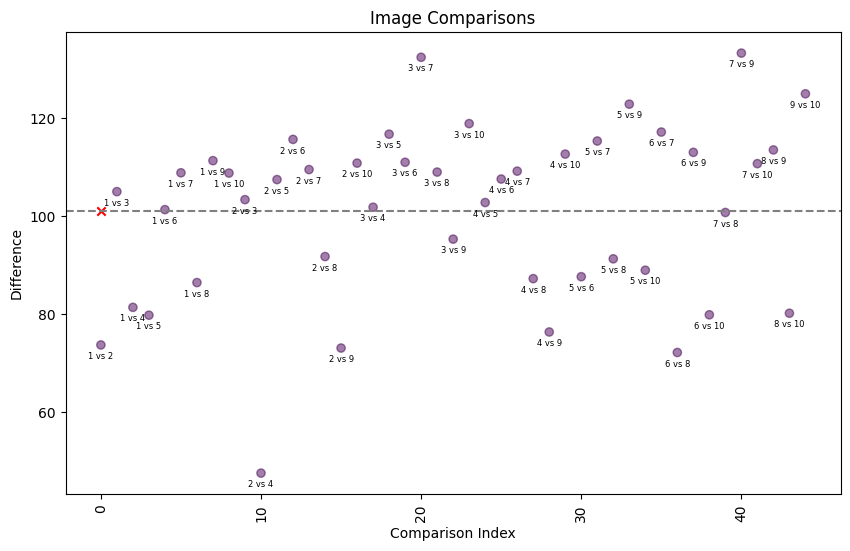

Centroids: [[101.11705684]]


In [101]:
visualize_comparisons(new_comparisons)

*The above graph quantifies the similarity amongst all the images in our dataset. The line passing through the centroid represents the average similarity between any two arbitrary images in our dataset. Images below this threshold show more similarity while Images above this threshold show higher similarity*

*function to determine comparison for a specific label*

In [32]:
image_urls_2 = get_images()
print(image_urls_2)

{'meditative-rose': 'https://uploads0.wikiart.org/images/salvador-dali/meditative-rose.jpg!Large.jpg', 'the-great-wave-off-kanagawa': 'https://uploads6.wikiart.org/00129/images/katsushika-hokusai/the-great-wave-off-kanagawa.jpg!Large.jpg', 'girl-in-a-blanket-1953': 'https://uploads6.wikiart.org/images/lucian-freud/girl-in-a-blanket-1953.jpg!Large.jpg', 'self-portrait-with-hands-on-chest-1910': 'https://uploads4.wikiart.org/images/egon-schiele/self-portrait-with-hands-on-chest-1910.jpg!Large.jpg', 'bird-fish': 'https://uploads0.wikiart.org/images/m-c-escher/bird-fish.jpg!Large.jpg', 'breton-woman-and-goose-by-the-water-1888': 'https://uploads6.wikiart.org/images/paul-gauguin/breton-woman-and-goose-by-the-water-1888.jpg!Large.jpg'}


In [24]:
def compare_images_label_similarity(images, label):

    print('images: ', json.dumps(image_urls_2, indent=4))

    image_description_labels = {}
    i = 0

    for image_name, image_url in image_urls_2.items():
        description = image_to_text(image_url)
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes
        i += 1
        print(i)

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_label_dissimilarity(image_description_labels[image1], image_description_labels[image2], label, "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return comparisons

In [124]:
label_comparison = compare_images_label_similarity(image_urls_2, "Color Palette")
print(label_comparison)

images:  {
    "portrait-of-ginevra-benci": "https://uploads5.wikiart.org/images/leonardo-da-vinci/portrait-of-ginevra-benci.jpg!Large.jpg",
    "the-barefoot-girl-1895": "https://uploads7.wikiart.org/images/pablo-picasso/the-barefoot-girl-1895.jpg!Large.jpg",
    "branches-with-almond-blossom-1890(1)": "https://uploads6.wikiart.org/images/vincent-van-gogh/branches-with-almond-blossom-1890(1).jpg!Large.jpg",
    "poison-oasis": "https://uploads4.wikiart.org/images/jean-michel-basquiat/poison-oasis.jpg!Large.jpg",
    "the-scream-1893(2)": "https://uploads2.wikiart.org/images/edvard-munch/the-scream-1893(2).jpg!Large.jpg",
    "girl-on-the-ball-1905": "https://uploads6.wikiart.org/images/pablo-picasso/girl-on-the-ball-1905.jpg!Large.jpg"
}
{
    "Color Palette": ["Muted", "Earthy", "Pastel", "Monochromatic", "Vibrant", "Bold", "Neon"],
    "Subject Matter": ["Portrait", "Abstract", "Nature", "Landscape", "Still life", "Urban", "Architecture"],
    "Mood/Emotion": ["Serene", "Mysterious"

In [128]:
new_label_comparisons = []

for comparison in label_comparison:
    # seperate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    # create a new key with the two image names based on their indices in the image_urls dictionary
    new_key = f"{list(image_urls_2.keys()).index(image1) + 1} vs {list(image_urls_2.keys()).index(image2) + 1}"
    new_label_comparisons.append((new_key, comparison[1]))

print(len(new_label_comparisons))
print(json.dumps(new_label_comparisons, indent=4))

15
[
    [
        "1 vs 2",
        5.039948288106981
    ],
    [
        "1 vs 3",
        16.33697201343942
    ],
    [
        "1 vs 4",
        22.4025930417305
    ],
    [
        "1 vs 5",
        18.52097760749216
    ],
    [
        "1 vs 6",
        6.681499338991745
    ],
    [
        "2 vs 3",
        16.164678486940403
    ],
    [
        "2 vs 4",
        22.472820653270475
    ],
    [
        "2 vs 5",
        18.450749995952187
    ],
    [
        "2 vs 6",
        8.456697018248079
    ],
    [
        "3 vs 4",
        14.2463500053261
    ],
    [
        "3 vs 5",
        10.602776468663833
    ],
    [
        "3 vs 6",
        12.752317372890118
    ],
    [
        "4 vs 5",
        8.656505277335334
    ],
    [
        "4 vs 6",
        22.008557435147786
    ],
    [
        "5 vs 6",
        18.30610272612793
    ]
]


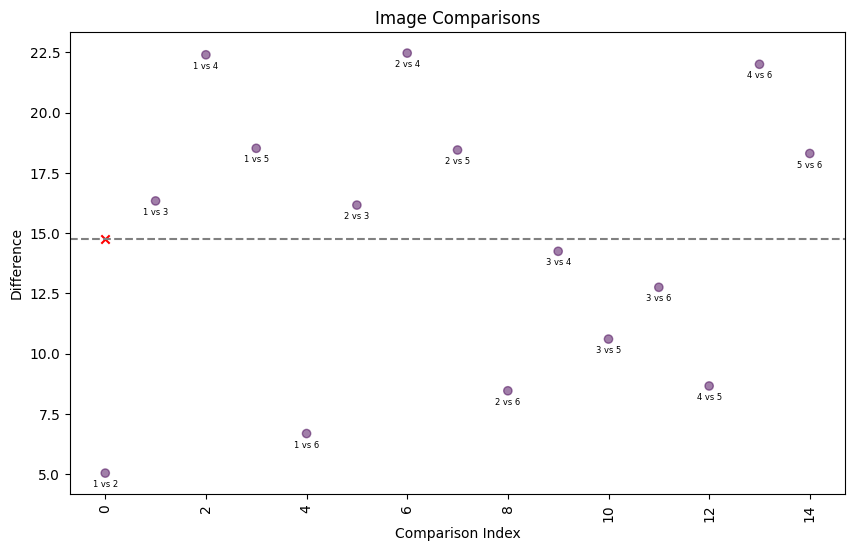

Centroids: [[14.73996972]]


In [129]:
visualize_comparisons(new_label_comparisons)

### Jean Michel Busquait Testing with Neo-Expression

*Method to pull a specific image URL from the API*

In [25]:
def get_image_by_name(image_name):
    # Define the base URL for the WikiArt API
    base_url = "https://www.wikiart.org/en/App/Painting/MostViewedPaintings"

    # Define the parameters for the API request
    params = {
        "randomSeed": int(time.time()),
        "json": 2,
        "inPublicDomain": True,
    }

    # Send a GET request to the WikiArt API
    response = requests.get(base_url, params=params)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Find the image with the specified name
        for painting in data:
            if painting["title"] == image_name:
                return painting["image"]

        # If image not found, return None
        print(f"Image '{image_name}' not found.")
        return None
    else:
        print(f"Failed to get data from WikiArt API: {response.status_code}")
        return None

In [35]:
image_name_1 = "Philistines"  # Replace this with the desired image name
image_url_JMB1 = get_image_by_name(image_name_1)
if image_url_JMB1:
    print(f"URL for '{image_name_1}': {image_url_JMB1}")

image_name_2 = "Skull"  # Replace this with the desired image name
image_url_JMB2 = get_image_by_name(image_name_2)
if image_url_JMB2:
    print(f"URL for '{image_name_2}': {image_url_JMB2}")

URL for 'Philistines': https://uploads3.wikiart.org/images/jean-michel-basquiat/philistines.jpg!Large.jpg
URL for 'Skull': https://uploads5.wikiart.org/images/jean-michel-basquiat/head.jpg!Large.jpg


In [37]:
image_urls_2[image_name_1] = image_url_JMB1
image_urls_2[image_name_2] = image_url_JMB2
print(image_urls_2)

{'meditative-rose': 'https://uploads0.wikiart.org/images/salvador-dali/meditative-rose.jpg!Large.jpg', 'the-great-wave-off-kanagawa': 'https://uploads6.wikiart.org/00129/images/katsushika-hokusai/the-great-wave-off-kanagawa.jpg!Large.jpg', 'girl-in-a-blanket-1953': 'https://uploads6.wikiart.org/images/lucian-freud/girl-in-a-blanket-1953.jpg!Large.jpg', 'self-portrait-with-hands-on-chest-1910': 'https://uploads4.wikiart.org/images/egon-schiele/self-portrait-with-hands-on-chest-1910.jpg!Large.jpg', 'bird-fish': 'https://uploads0.wikiart.org/images/m-c-escher/bird-fish.jpg!Large.jpg', 'breton-woman-and-goose-by-the-water-1888': 'https://uploads6.wikiart.org/images/paul-gauguin/breton-woman-and-goose-by-the-water-1888.jpg!Large.jpg', 'Philistines': 'https://uploads3.wikiart.org/images/jean-michel-basquiat/philistines.jpg!Large.jpg', 'Skull': 'https://uploads5.wikiart.org/images/jean-michel-basquiat/head.jpg!Large.jpg'}


In [39]:
label_comparison = compare_images_label_similarity(image_urls_2, "Style/Aesthetic")
print(label_comparison)

images:  {
    "meditative-rose": "https://uploads0.wikiart.org/images/salvador-dali/meditative-rose.jpg!Large.jpg",
    "the-great-wave-off-kanagawa": "https://uploads6.wikiart.org/00129/images/katsushika-hokusai/the-great-wave-off-kanagawa.jpg!Large.jpg",
    "girl-in-a-blanket-1953": "https://uploads6.wikiart.org/images/lucian-freud/girl-in-a-blanket-1953.jpg!Large.jpg",
    "self-portrait-with-hands-on-chest-1910": "https://uploads4.wikiart.org/images/egon-schiele/self-portrait-with-hands-on-chest-1910.jpg!Large.jpg",
    "bird-fish": "https://uploads0.wikiart.org/images/m-c-escher/bird-fish.jpg!Large.jpg",
    "breton-woman-and-goose-by-the-water-1888": "https://uploads6.wikiart.org/images/paul-gauguin/breton-woman-and-goose-by-the-water-1888.jpg!Large.jpg",
    "Philistines": "https://uploads3.wikiart.org/images/jean-michel-basquiat/philistines.jpg!Large.jpg",
    "Skull": "https://uploads5.wikiart.org/images/jean-michel-basquiat/head.jpg!Large.jpg"
}
{
    "Color Palette": ["Vib

In [40]:
new_label_comparisons = []

for comparison in label_comparison:
    # seperate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    # create a new key with the two image names based on their indices in the image_urls dictionary
    new_key = f"{list(image_urls_2.keys()).index(image1) + 1} vs {list(image_urls_2.keys()).index(image2) + 1}"
    new_label_comparisons.append((new_key, comparison[1]))

print(len(new_label_comparisons))
print(json.dumps(new_label_comparisons, indent=4))

28
[
    [
        "1 vs 2",
        11.050965303961156
    ],
    [
        "1 vs 3",
        14.970008667361771
    ],
    [
        "1 vs 4",
        13.169933924386175
    ],
    [
        "1 vs 5",
        12.871526923717884
    ],
    [
        "1 vs 6",
        14.809177295989997
    ],
    [
        "1 vs 7",
        16.933551528654043
    ],
    [
        "1 vs 8",
        16.853444527902028
    ],
    [
        "2 vs 3",
        11.2085586760024
    ],
    [
        "2 vs 4",
        7.0929174974164475
    ],
    [
        "2 vs 5",
        16.750188144081076
    ],
    [
        "2 vs 6",
        15.140971263767984
    ],
    [
        "2 vs 7",
        16.908691148413265
    ],
    [
        "2 vs 8",
        12.933551528654041
    ],
    [
        "3 vs 4",
        14.899705187691826
    ],
    [
        "3 vs 5",
        18.863977838623995
    ],
    [
        "3 vs 6",
        11.147566440447676
    ],
    [
        "3 vs 7",
        18.884296973160858
    ],
    [
     

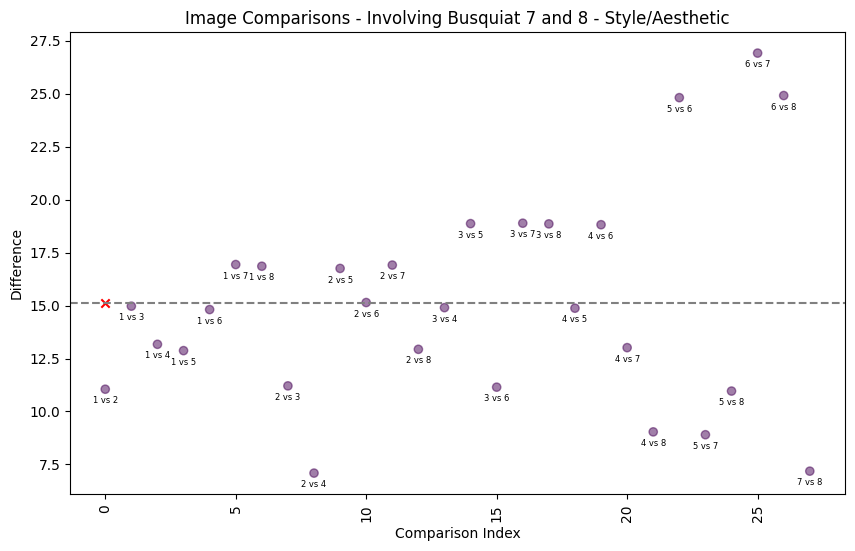

Centroids: [[15.09836343]]


In [43]:
visualize_comparisons(new_label_comparisons)

### Comparing Images for the same artist across years

#### Function to pull images from a specific artist

In [26]:
def get_images_from_most_viewed(artist_name):
    base_url = "https://www.wikiart.org/en/App/Painting/MostViewedPaintings"

    # Define the parameters for the API request
    params = {
        "json": 2,
    }

    # Send a GET request to the WikiArt API
    response = requests.get(base_url, params=params)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Filter paintings by the specified artist
        artist_paintings = [painting for painting in data if artist_name.lower() in painting["artistName"].lower()]

        # URLs and years
        image_info = {}

        # Extract image URLs and years of paintings by the specified artist from the most viewed list
        for painting in artist_paintings:
            if is_url_valid(painting["image"]):
                image_info[painting["title"]] = {"url": painting["image"], "year": painting["completitionYear"]}

        return image_info

    else:
        print(f"Failed to get data from WikiArt API: {response.status_code}")
        return None

In [37]:
artist_name = "Salvador Dali"
artist_images = get_images_from_most_viewed(artist_name)
if artist_images:
    print(f"Found {len(artist_images)} images by {artist_name}:")
    for name, url in artist_images.items():
        print(f"{name}: {url}")

Found 11 images by Salvador Dali:
The Persistence of Memory: {'url': 'https://uploads1.wikiart.org/00475/images/salvador-dali/w1siziisijm4njq3mcjdlfsiccisimnvbnzlcnqilcitcxvhbgl0esa5mcatcmvzaxplidiwmdb4mjawmfx1mdazzsjdxq.jpg!Large.jpg', 'year': 1931}
Ballerina in a Death's Head: {'url': 'https://uploads3.wikiart.org/images/salvador-dali/ballerina-in-a-death-s-head.jpg!Large.jpg', 'year': 1939}
The Disintegration of the Persistence of Memory: {'url': 'https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg', 'year': 1954}
The Great Masturbator: {'url': 'https://uploads3.wikiart.org/00475/images/salvador-dali/salvador-dali-the-great-masturbator-1929-obelisk-art-history.jpg!Large.jpg', 'year': 1929}
Women forming a skull: {'url': 'https://uploads6.wikiart.org/images/salvador-dali/women-forming-a-skull.jpg!Large.jpg', 'year': 1951}
Meditative Rose: {'url': 'https://uploads0.wikiart.org/images/salvador-dali/meditative-rose.jpg!Large.jp

In [27]:
def compare_images_total_similarity_years(images):

    print('images: ', json.dumps(images, indent=4))

    image_description_labels = {}
    i = 0

    for image_name, image_info in images.items():
        description = image_to_text(image_info['url'])
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes
        i += 1
        print(i)

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference  = calculate_total_similarity(image_description_labels[image1], image_description_labels[image2], "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return image_description_labels, comparisons

In [28]:
def compare_images_label_similarity_years(images, label):

    print('images: ', json.dumps(images, indent=4))

    image_description_labels = {}
    i = 0

    for image_name, image_info in images.items():
        description = image_to_text(image_info['url'])
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes
        i += 1
        print(i)

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_label_dissimilarity(image_description_labels[image1], image_description_labels[image2], label, "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return comparisons

In [42]:
dali_comparisons = compare_images_label_similarity_years(artist_images, "Style/Aesthetic")

images:  {
    "The Persistence of Memory": {
        "url": "https://uploads1.wikiart.org/00475/images/salvador-dali/w1siziisijm4njq3mcjdlfsiccisimnvbnzlcnqilcitcxvhbgl0esa5mcatcmvzaxplidiwmdb4mjawmfx1mdazzsjdxq.jpg!Large.jpg",
        "year": 1931
    },
    "Ballerina in a Death's Head": {
        "url": "https://uploads3.wikiart.org/images/salvador-dali/ballerina-in-a-death-s-head.jpg!Large.jpg",
        "year": 1939
    },
    "The Disintegration of the Persistence of Memory": {
        "url": "https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg",
        "year": 1954
    },
    "The Great Masturbator": {
        "url": "https://uploads3.wikiart.org/00475/images/salvador-dali/salvador-dali-the-great-masturbator-1929-obelisk-art-history.jpg!Large.jpg",
        "year": 1929
    },
    "Women forming a skull": {
        "url": "https://uploads6.wikiart.org/images/salvador-dali/women-forming-a-skull.jpg!Large.jpg",
        "y

In [58]:
dali_image_descriptions, total_dali_comparisons = compare_images_total_similarity_years(artist_images)
print(total_dali_comparisons)

images:  {
    "The Persistence of Memory": {
        "url": "https://uploads1.wikiart.org/00475/images/salvador-dali/w1siziisijm4njq3mcjdlfsiccisimnvbnzlcnqilcitcxvhbgl0esa5mcatcmvzaxplidiwmdb4mjawmfx1mdazzsjdxq.jpg!Large.jpg",
        "year": 1931
    },
    "Ballerina in a Death's Head": {
        "url": "https://uploads3.wikiart.org/images/salvador-dali/ballerina-in-a-death-s-head.jpg!Large.jpg",
        "year": 1939
    },
    "The Disintegration of the Persistence of Memory": {
        "url": "https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg",
        "year": 1954
    },
    "The Great Masturbator": {
        "url": "https://uploads3.wikiart.org/00475/images/salvador-dali/salvador-dali-the-great-masturbator-1929-obelisk-art-history.jpg!Large.jpg",
        "year": 1929
    },
    "Women forming a skull": {
        "url": "https://uploads6.wikiart.org/images/salvador-dali/women-forming-a-skull.jpg!Large.jpg",
        "y

In [44]:
print(dali_comparisons)

[("The Persistence of Memory vs Ballerina in a Death's Head", 12.886061377431837), ('The Persistence of Memory vs The Disintegration of the Persistence of Memory', 5.358883402553079), ('The Persistence of Memory vs The Great Masturbator', 10.90864569446277), ('The Persistence of Memory vs Women forming a skull', 11.031465993669975), ('The Persistence of Memory vs Meditative Rose', 8.982107112804687), ('The Persistence of Memory vs Landscape', 18.806866152170933), ('The Persistence of Memory vs The Discovery of America by Christopher Columbus', 13.03395769903404), ('The Persistence of Memory vs Fiesta in Figueres', 20.810903314014265), ('The Persistence of Memory vs The Enigma of My Desire or My Mother, My Mother, My Mother', 11.191518865554547), ('The Persistence of Memory vs Ascension', 8.996697539847618), ("Ballerina in a Death's Head vs The Disintegration of the Persistence of Memory", 11.027177939505457), ("Ballerina in a Death's Head vs The Great Masturbator", 8.928682994677324), 

In [45]:
new_label_comparisons = []

for comparison in dali_comparisons:
    # Separate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    
    # Extract the years corresponding to the images
    year1 = artist_images[image1]['year']
    year2 = artist_images[image2]['year']
    
    # Create a new key with the years instead of image names
    new_key = f"{year1} vs {year2}"
    new_label_comparisons.append((new_key, comparison[1]))

print(len(new_label_comparisons))
print(json.dumps(new_label_comparisons, indent=4))

55
[
    [
        "1931 vs 1939",
        12.886061377431837
    ],
    [
        "1931 vs 1954",
        5.358883402553079
    ],
    [
        "1931 vs 1929",
        10.90864569446277
    ],
    [
        "1931 vs 1951",
        11.031465993669975
    ],
    [
        "1931 vs 1958",
        8.982107112804687
    ],
    [
        "1931 vs 1914",
        18.806866152170933
    ],
    [
        "1931 vs 1959",
        13.03395769903404
    ],
    [
        "1931 vs 1916",
        20.810903314014265
    ],
    [
        "1931 vs 1929",
        11.191518865554547
    ],
    [
        "1931 vs 1958",
        8.996697539847618
    ],
    [
        "1939 vs 1954",
        11.027177939505457
    ],
    [
        "1939 vs 1929",
        8.928682994677324
    ],
    [
        "1939 vs 1951",
        11.116810287191202
    ],
    [
        "1939 vs 1958",
        10.840990550731068
    ],
    [
        "1939 vs 1914",
        12.772298183414343
    ],
    [
        "1939 vs 1959",
        11.

In [59]:
new_label_comparisons_2 = []

for comparison in total_dali_comparisons:
    # Separate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    
    # Extract the years corresponding to the images
    year1 = artist_images[image1]['year']
    year2 = artist_images[image2]['year']
    
    # Create a new key with the years instead of image names
    new_key = f"{year1} vs {year2}"
    new_label_comparisons_2.append((new_key, comparison[1]))

print(len(new_label_comparisons_2))
print(json.dumps(new_label_comparisons_2, indent=4))

55
[
    [
        "1931 vs 1939",
        78.20215788646527
    ],
    [
        "1931 vs 1954",
        66.53017363787774
    ],
    [
        "1931 vs 1929",
        70.82339583419684
    ],
    [
        "1931 vs 1951",
        83.75574885118672
    ],
    [
        "1931 vs 1958",
        84.35006192494944
    ],
    [
        "1931 vs 1914",
        97.20703751178452
    ],
    [
        "1931 vs 1959",
        90.09900712015103
    ],
    [
        "1931 vs 1916",
        134.79621107411097
    ],
    [
        "1931 vs 1929",
        77.9287422272738
    ],
    [
        "1931 vs 1958",
        85.44603155550706
    ],
    [
        "1939 vs 1954",
        80.58923384995383
    ],
    [
        "1939 vs 1929",
        85.20352671486567
    ],
    [
        "1939 vs 1951",
        72.38279727096929
    ],
    [
        "1939 vs 1958",
        81.54677192708043
    ],
    [
        "1939 vs 1914",
        105.01524375423098
    ],
    [
        "1939 vs 1959",
        81.90612740

In [26]:
def sort_by_year_difference(item):
    # Extract the years from the comparison key
    year1, year2 = map(int, item[0].split(' vs '))
    # Calculate the absolute difference between the years
    year_difference = abs(year1 - year2)
    return year_difference

# Sort the comparisons based on the difference between the years of the images
sorted_label_comparisons = sorted(new_label_comparisons, key=sort_by_year_difference)

# Print the sorted comparisons
print(json.dumps(sorted_label_comparisons, indent=4))

NameError: name 'new_label_comparisons' is not defined

In [60]:
total_sorted_label_comparisons = sorted(new_label_comparisons_2, key=sort_by_year_difference)
print(json.dumps(total_sorted_label_comparisons, indent=4))

[
    [
        "1929 vs 1929",
        77.38868424377205
    ],
    [
        "1958 vs 1958",
        92.87942972604887
    ],
    [
        "1958 vs 1959",
        87.26607707081007
    ],
    [
        "1959 vs 1958",
        75.89663310838971
    ],
    [
        "1931 vs 1929",
        70.82339583419684
    ],
    [
        "1931 vs 1929",
        77.9287422272738
    ],
    [
        "1914 vs 1916",
        120.77298254153762
    ],
    [
        "1954 vs 1951",
        63.46090473016052
    ],
    [
        "1954 vs 1958",
        86.28290359731582
    ],
    [
        "1954 vs 1958",
        70.12459788413044
    ],
    [
        "1954 vs 1959",
        89.29052931162633
    ],
    [
        "1951 vs 1958",
        60.969040321115926
    ],
    [
        "1951 vs 1958",
        75.94011731282608
    ],
    [
        "1931 vs 1939",
        78.20215788646527
    ],
    [
        "1951 vs 1959",
        80.0554978896872
    ],
    [
        "1939 vs 1929",
        85.203526714865

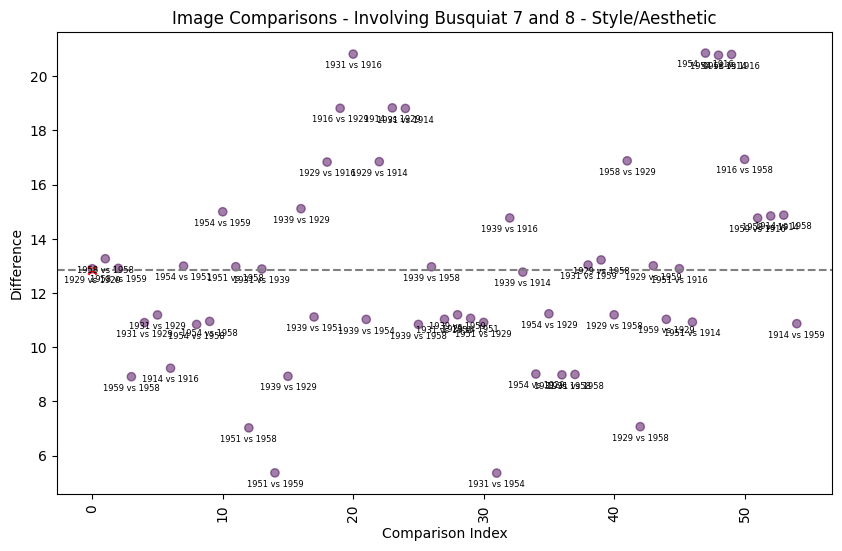

Centroids: [[12.86476156]]


In [47]:
visualize_comparisons(sorted_label_comparisons)

In [91]:
def visualize_comparisons_modified(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Reshape differences for KMeans clustering
    differences_array = [[diff] for diff in differences]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=1)
    kmeans.fit(differences_array)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    min_year_diff = 0
    max_year_diff = 48

    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(differences)), differences, c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(range(len(centroids)), centroids, marker='x', color='red')

    # Draw horizontal lines passing through each centroid
    for centroid in centroids:
        plt.axhline(y=centroid, color='gray', linestyle='--')

    # Annotate points with image comparison labels
    for i, (pair, diff) in enumerate(zip(image_pairs, differences)):
        plt.annotate(pair, (i, diff), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=6)  # Adjust fontsize here

    # Calculate and plot the best fit line
    x = range(len(differences))
    x = np.array(x).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, differences)
    y_pred = model.predict(x)
    plt.plot(x, y_pred, color='blue')

    plt.title('Image Comparisons - Picasso Portfolio - Year Based')
    plt.xlabel('Comparison Index')
    plt.ylabel('Dissimilarity')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

    # Calculate correlation between the line and the data
    correlation = np.corrcoef(differences, y_pred.reshape(-1))[0, 1]
    print("Correlation between the line and the data:", correlation)

    # Calculate the slope of the line
    slope = model.coef_[0]
    print("Slope of the line:", slope)

    print("Centroids:", centroids)


In [87]:
def visualize_comparisons_artists(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Extract the absolute year differences
    year_diffs = []

    for i in range(len(comparisons)):

        # extracting year 1 and year 2 from comparisons index 1
        image_diff_tuple = comparisons[i]
        image_names = image_diff_tuple[0]
        image_years = image_names.split(" vs ")
        year1 = int(image_years[0])
        year2 = int(image_years[1])
        year_diffs.append(abs(year1 - year2))

    # Plot the differences against similarity
    plt.figure(figsize=(10, 6))
    plt.scatter(year_diffs, differences, alpha=0.5)

    # Calculate and plot the best fit line
    x = np.array(year_diffs).reshape(-1, 1)
    y = np.array(differences)
    model = np.polyfit(year_diffs, differences, 1)
    y_pred = np.polyval(model, year_diffs)
    plt.plot(year_diffs, y_pred, color='red')

    plt.title('Image Similarity vs. Absolute Year Difference')
    plt.xlabel('Absolute Year Difference')
    plt.ylabel('Similarity')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.show()

    correlation = np.corrcoef(differences, y_pred.reshape(-1))[0, 1]
    print("Correlation between the line and the data:", correlation)

    # Calculate the slope of the line
    slope = model[0]
    print("Slope of the line:", slope)

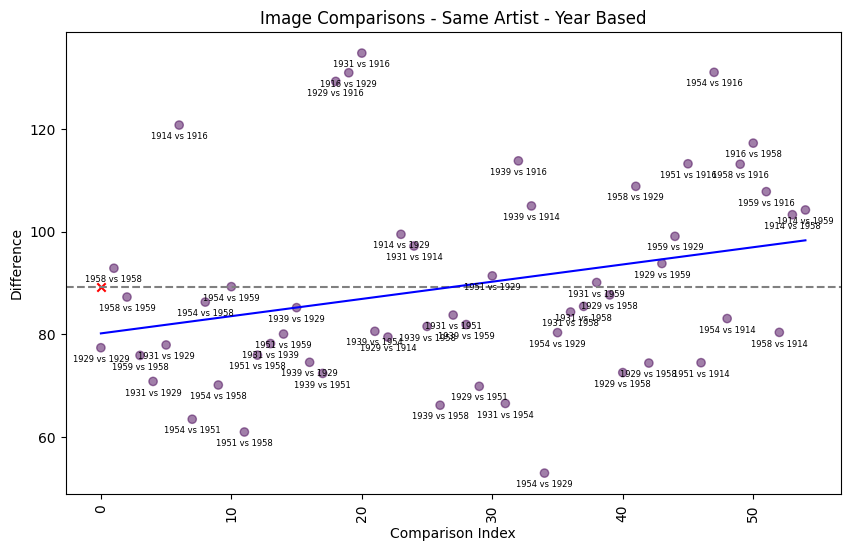

Centroids: [[89.24912633]]


In [68]:
visualize_comparisons_modified(total_sorted_label_comparisons)

#### Above graph shows that the difference in similiarty between works by the same artist increases as the difference in the years in whcih they were painted. This makes sense since artist's for example are more likely to paint similar images in their 20s or 50s rather than paint 2 similar images - one in their 20s and the other in their 50s. 

#### This serves as a domain-specific verification that our similarity function is able to qunatify these intersectional motifs within art in a consistent manner.

# Final Version of Code

### Final Version of Getting Valid Attributes from Images with Trouble Shooting

#### function to validate attributes - replace new ones with predefined ones

In [30]:
def final_validate_attributes(attributes_dict, predefined_list):
    for key, values in attributes_dict.items():
        # Filter out invalid values
        valid_values = [value for value in values if value in predefined_list[key]]
        
        # If there are missing values, append predefined values at the end
        if len(valid_values) < len(values):
            # Get the predefined values that are not in valid_values
            missing_values = [value for value in predefined_list[key] if value not in valid_values]
            
            # Append the missing values at the end of valid_values
            valid_values.extend(missing_values[:len(values)-len(valid_values)])
        
        # Replace the original values with the valid values
        attributes_dict[key] = valid_values

    return attributes_dict


#### function to validate the formatting of attribute contents before loading into JSON

In [31]:
def final_validate_attributes_content(attribute_content):
    if '```json' in attribute_content:
        attribute_content = attribute_content.replace('```json', '')
        attribute_content = attribute_content.replace('```', '')
    
    # Find the first occurrence of '{' and the last occurrence of '}'
    start_index = attribute_content.find('{')
    end_index = attribute_content.rfind('}')

    # If '{' and '}' are found, slice the string to include only the content within these brackets
    if start_index != 0 and end_index != len(attribute_content) - 1:
        attribute_content = attribute_content[start_index:end_index+1]

    try:
        json.loads(attribute_content)
    except json.JSONDecodeError:
        return '{}'
    
    return attribute_content

#### Final function to get pre-defined attributes from description of images

In [32]:
def final_description_to_all_attributes(description):

    predefined_list = {
        'Color Palette': ['Vibrant', 'Monochromatic', 'Pastel', 'Earthy', 'Neon', 'Muted', 'Bold'],
        'Subject Matter': ['Landscape', 'Portrait', 'Still life', 'Abstract', 'Urban', 'Nature', 'Architecture'],
        'Mood/Emotion': ['Serene', 'Energetic', 'Melancholic', 'Joyful', 'Mysterious', 'Peaceful', 'Dramatic'],
        'Style/Aesthetic': ['Realism', 'Impressionism', 'Surrealism', 'Minimalism', 'Expressionism', 'Cubism', 'Romanticism'],
        'Setting/Location': ['Cityscape', 'Countryside', 'Beach', 'Forest', 'Mountains', 'Urban', 'Rural'],
        'Time Period': ['Contemporary', 'Renaissance', 'Medieval', 'Modern', 'Ancient', 'Futuristic', 'Victorian'],
        'Cultural/Symbolic Representation': ['Religious', 'Political', 'Mythological', 'Historical', 'Indigenous', 'Pop culture', 'Folklore']
    }


    response = client.chat.completions.create(
        model = "gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": f"""
                You are a machine learning model trained to extract specific attributes from a detailed 
                description of an image. Your task is to identify and select the most appropriate label from 
                the following pre-defined set of attributes for each of the seven categories given below, and
                represent them as key-value pairs in a Python dictionary: 

                1. Color Palette: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Color Palette']}. 

                2. Subject Matter: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Subject Matter']}. 

                3. Mood/Emotion: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Mood/Emotion']}. 

                4. Style/Aesthetic: Select exactly 7 labels without repetition from ONLY the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Style/Aesthetic']}. 

                5. Setting/Location: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Setting/Location']}. 

                6. Time Period: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Time Period']}.

                7. Cultural/Symbolic Representation: Select Exactly 7 labels without repetition from only the 
                following options, ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Cultural/Symbolic Representation']}

                Please provide your output in the following format:  
                {{'Color Palette': ['most associated label', ..., 'least associated label'],  
                'Subject Matter': ['most associated label', ..., 'least associated label'],  
                'Mood/Emotion': ['most associated label', ..., 'least associated label'], 
                'Style/Aesthetic': ['most associated label', ..., 'least associated label'],  
                'Setting/Location': ['most associated label', ..., 'least associated label'],  
                'Time Period': ['most associated label', ..., 'least associated label'],  
                'Cultural/Symbolic Representation': ['most associated label', ..., 'least associated label']}}. 

                If an attribute is not obvious, infer from the context of the description an attribute, 
                don't use 'none' or 'not specified' as an attribute. Remember, you MUST ONLY select attribute values from the provided
                list of options. DO NOT assign any attribute that is not present in the pre-defined attributes. I repeat - no label in the result should be outside the predefined 
                set of labels for each attribute. Format the output in double quotations so it can be 
                converted into an object with json. The description is as follows:""" + description
            }
        ],
        max_tokens=500,
    )
    
    attributes_content = response.choices[0].message.content
    attributes_content = final_validate_attributes_content(attributes_content)

    try:
        attributes_dict = json.loads(attributes_content)
    except json.JSONDecodeError:
        attributes_dict = '{}'
    
    attributes_dict = final_validate_attributes(attributes_dict, predefined_list)

    return attributes_dict

In [33]:
def final_get_image_description_labels(images):
    image_description_labels = {}
    i = 0
    for image_name, image_info in images.items():
        description = image_to_text(image_info['url'])
        attributes = final_description_to_all_attributes(description)
        image_description_labels[image_name] = attributes
        i = i + 1
        print("Image Processed: ", i)
    return image_description_labels

def final_calculate_total_image_comparisons(image_description_labels, model):
    comparisons = []
    highest_similarity_pair = None
    lowest_similarity_pair = None
    highest_similarity = float('-inf')
    lowest_similarity = float('inf')
    
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_total_similarity(image_description_labels[image1], image_description_labels[image2], model)
        comparisons.append((f"{image1} vs {image2}", difference))
        
        # Update highest and lowest similarity pair
        if difference > highest_similarity:
            highest_similarity = difference
            highest_similarity_pair = (image1, image2)
        if difference < lowest_similarity:
            lowest_similarity = difference
            lowest_similarity_pair = (image1, image2)
    
    return comparisons, highest_similarity_pair, lowest_similarity_pair

def final_calculate_label_comparisons(image_description_labels, label, model):
    comparisons = []
    highest_similarity_pair = None
    lowest_similarity_pair = None
    highest_similarity = float('-inf')
    lowest_similarity = float('inf')
    
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_label_dissimilarity(image_description_labels[image1], image_description_labels[image2], label, model)
        comparisons.append((f"{image1} vs {image2}", difference))
        
        # Update highest and lowest similarity pair
        if difference > highest_similarity:
            highest_similarity = difference
            highest_similarity_pair = (image1, image2)
        if difference < lowest_similarity:
            lowest_similarity = difference
            lowest_similarity_pair = (image1, image2)
    
    return comparisons, highest_similarity_pair, lowest_similarity_pair


# Demonstration Code

## Start: Comparing Images from the Same Artist Across Years

In [34]:
# Putting Artist that whose images are to be compared
artist_name = "Pablo Picasso"
picasso_images = get_images_from_most_viewed(artist_name)

if picasso_images:
    print(f"Found {len(picasso_images)} images by {artist_name}:")
    for name, url in picasso_images.items():
        print(f"{name}: {url}")

Found 19 images by Pablo Picasso:
Self-Portrait: {'url': 'https://uploads3.wikiart.org/images/pablo-picasso/self-portrait-1896.jpg!Large.jpg', 'year': 1896}
Portrait of woman in d`hermine pass (Olga): {'url': 'https://uploads0.wikiart.org/images/pablo-picasso/untitled-1937-8.jpg!Large.jpg', 'year': 1923}
Science and Charity: {'url': 'https://uploads0.wikiart.org/images/pablo-picasso/science-and-charity-1897.jpg!Large.jpg', 'year': 1897}
Child with dove: {'url': 'https://uploads5.wikiart.org/images/pablo-picasso/child-with-dove-1901.jpg!Large.jpg', 'year': 1901}
The picador: {'url': 'https://uploads1.wikiart.org/images/pablo-picasso/the-picador-1890.jpg!Large.jpg', 'year': 1890}
First Communion: {'url': 'https://uploads5.wikiart.org/00451/images/pablo-picasso/1900first-communion.jpg!Large.jpg', 'year': 1896}
Plaster male torso: {'url': 'https://uploads8.wikiart.org/images/pablo-picasso/plaster-male-torso-1893.jpg!Large.jpg', 'year': 1893}
Academical study: {'url': 'https://uploads1.wiki

In [35]:
# getting differences between all images in the artist's portfolio across all attributes
picasso_image_descriptions = final_get_image_description_labels(picasso_images)

Image Processed:  1
Image Processed:  2
Image Processed:  3
Image Processed:  4
Image Processed:  5
Image Processed:  6
Image Processed:  7
Image Processed:  8
Image Processed:  9
Image Processed:  10
Image Processed:  11
Image Processed:  12
Image Processed:  13
Image Processed:  14
Image Processed:  15
Image Processed:  16
Image Processed:  17
Image Processed:  18
Image Processed:  19


In [36]:
total_picasso_comparisons, highest_sim_picasso_total, lowest_sim_picasso_total = final_calculate_total_image_comparisons(picasso_image_descriptions, "bert")
style_picasso_comparisons, highest_sim_picasso_style, lowest_sim_picasso_style = final_calculate_label_comparisons(picasso_image_descriptions, "Style/Aesthetic", "bert")

print(total_picasso_comparisons)
print(style_picasso_comparisons)
print(highest_sim_picasso_total)
print(lowest_sim_picasso_total)
print(highest_sim_picasso_style)
print(lowest_sim_picasso_style)

[('Self-Portrait vs Portrait of woman in d`hermine pass (Olga)', 111.28688525836843), ('Self-Portrait vs Science and Charity', 70.84528054211094), ('Self-Portrait vs Child with dove', 66.64677628350458), ('Self-Portrait vs The picador', 93.52534552232976), ('Self-Portrait vs First Communion', 66.6786773817012), ('Self-Portrait vs Plaster male torso', 78.46712746887825), ('Self-Portrait vs Academical study', 51.13965768404702), ('Self-Portrait vs Girl on the ball', 76.2048194364931), ('Self-Portrait vs The barefoot girl', 70.26907601339816), ('Self-Portrait vs The girls of Avignon', 98.45421853808551), ('Self-Portrait vs Portrait of Dora Maar', 110.91556492982987), ('Self-Portrait vs Portrait of aunt Pepa', 72.3931265738972), ('Self-Portrait vs A rooster', 109.78941546125635), ('Self-Portrait vs Portrait of Ambroise Vollard', 95.48873452138838), ('Self-Portrait vs Bust of young man', 88.39408136455715), ('Self-Portrait vs Mother and Child', 76.6609622377357), ('Self-Portrait vs The old 

#### function to convert formatting of images to year1 vs year2

In [37]:
def label_change_year(comparisons, artist_images):

    year_comparisons = []

    for comparison in comparisons:
        # Separate the first image name and the second image name
        image1, image2 = comparison[0].split(' vs ')
        
        # Extract the years corresponding to the images
        year1 = artist_images[image1]['year']
        year2 = artist_images[image2]['year']
        
        # Create a new key with the years instead of image names
        new_key = f"{year1} vs {year2}"
        year_comparisons.append((new_key, comparison[1]))

    return year_comparisons

#### function to order year based comparions object based on the difference in year

In [38]:
def final_sort_comparisons_by_year_difference(comparisons):

    def year_difference(item):
        year1, year2 = map(int, item[0].split(' vs '))
        return abs(year1 - year2)
    
    return sorted(comparisons, key=year_difference)

#### running it all

In [113]:
year_sorted_picasso_comparisons_total = final_sort_comparisons_by_year_difference(label_change_year(total_picasso_comparisons, picasso_images))
# print(json.dumps(year_sorted_picasso_comparisons_total, indent=4))

## *VISUALIZATION

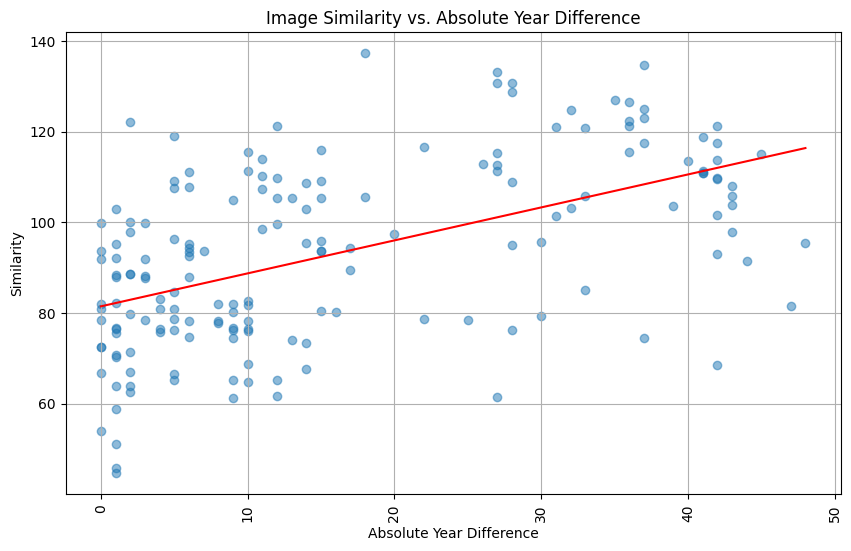

Correlation between the line and the data: 0.5315776454317004
Slope of the line: 0.7275259711653045


In [114]:
#visualize_comparisons_modified(year_sorted_picasso_comparisons_total)
visualize_comparisons_artists(year_sorted_picasso_comparisons_total)

In [ ]:
year_sorted_picasso_comparisons_style = final_sort_comparisons_by_year_difference(label_change_year(style_picasso_comparisons, picasso_images))
visualize_comparisons_artists(year_sorted_picasso_comparisons_style)

### Conclusion - The observed positive correlation between the dissimilarity in images and the magnitude of the difference between the years in which two images were painted highlights the effectiveness of our similarity metric in accurately quantifying commonalities between images - since this supports our hypothesis that "the difference between two images increases as the difference in years between images by the same artist increases".

## END : Comparing Images between Same artists.

#### 

## START: Comparing Images between Different Artists

In [95]:
artist1 = "Raphael"
artist2 = "Frida Kahlo"

artist1_images = get_images_from_most_viewed(artist1)
artist2_images = get_images_from_most_viewed(artist2)

# concat artist 1  images with artist 2 images
# add an attribute to each image which is the artist name

for image_name, image_info in artist1_images.items():
    image_info['artist'] = artist1

for image_name, image_info in artist2_images.items():
    image_info['artist'] = artist2

# combine the images from both artists
both_artist_images = {**artist1_images, **artist2_images}

# print all images

if both_artist_images:
    print(f"Found {len(both_artist_images)} images by {artist1} and {artist2}:")
    for name, url in both_artist_images.items():
        print(f"{name}: {url}")

Found 12 images by Raphael and Frida Kahlo:
The School of Athens: {'url': 'https://uploads6.wikiart.org/00475/images/raphael/1-xvkpn0qm3eiqpzivkggfea.jpg!Large.jpg', 'year': 1511, 'artist': 'Raphael'}
Madonna and Child: {'url': 'https://uploads5.wikiart.org/images/raphael/madonna-and-child.jpg!Large.jpg', 'year': 1503, 'artist': 'Raphael'}
The Triumph of Galatea: {'url': 'https://uploads3.wikiart.org/images/raphael/galatea-detail-of-mermen-and-dolphins-1506.jpg!Large.jpg', 'year': 1512, 'artist': 'Raphael'}
Putti, detail from The Sistine Madonna: {'url': 'https://uploads3.wikiart.org/images/raphael/putti-detail-from-the-sistine-madonna-1513.jpg!Large.jpg', 'year': 1513, 'artist': 'Raphael'}
The Two Fridas: {'url': 'https://uploads5.wikiart.org/images/magdalena-carmen-frieda-kahlo-y-calderón-de-rivera/the-two-fridas-1939.jpg!Large.jpg', 'year': 1939, 'artist': 'Frida Kahlo'}
The Wounded Deer: {'url': 'https://uploads7.wikiart.org/images/magdalena-carmen-frieda-kahlo-y-calderón-de-rivera

In [96]:
# get description fo all images
both_artist_image_descriptions = final_get_image_description_labels(both_artist_images)

Image Processed:  1
Image Processed:  2
Image Processed:  3
Image Processed:  4
Image Processed:  5
Image Processed:  6
Image Processed:  7
Image Processed:  8
Image Processed:  9
Image Processed:  10
Image Processed:  11
Image Processed:  12


In [98]:
def label_change_artist(comparisons, artist_images):

    artist_comparisons = []

    for comparison in comparisons:
        # Separate the first image name and the second image name
        image1, image2 = comparison[0].split(' vs ')
        
        # Extract the artist names corresponding to the images
        artist1 = artist_images[image1]['artist']
        artist2 = artist_images[image2]['artist']
        
        # Create a new key with the artist names instead of image names
        new_key = f"{artist1} vs {artist2}"
        artist_comparisons.append((new_key, comparison[1]))

    return artist_comparisons

In [110]:
def visualize_comparisons_two_artists(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Determine whether each comparison is between images of the same artist or different artists
    same_artist = []
    for comparison in comparisons:
        image1, image2 = comparison[0].split(' vs ')
        same_artist.append(image1 == image2)

    # Plot the differences
    plt.figure(figsize=(10, 6))
    colors = ['blue' if same else 'green' for same in same_artist]
    plt.scatter(range(len(differences)), differences, c=colors, alpha=0.5)

    # Calculate average values for blue and red dots
    blue_differences = [diff for same, diff in zip(same_artist, differences) if same]
    red_differences = [diff for same, diff in zip(same_artist, differences) if not same]
    avg_blue = np.mean(blue_differences)
    avg_red = np.mean(red_differences)

    # Find the index of the maximum and minimum differences
    max_diff_index = np.argmax(differences)
    min_diff_index = np.argmin(differences)

    # Annotate points with image comparison labels
    #for i, (pair, diff) in enumerate(zip(image_pairs, differences)):
    #    plt.annotate(pair, (i, diff), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=6)

    # Plot horizontal lines for average values
    plt.axhline(y=avg_blue, color='blue', linestyle='--', label=f'Avg Blue (Same Artist): {avg_blue:.2f}')
    plt.axhline(y=avg_red, color='green', linestyle='--', label=f'Avg Green (Different Artist): {avg_red:.2f}')

    # Highlight the points with the lowest and highest similarity scores
    #plt.scatter(min_diff_index, differences[min_diff_index], color='green', marker='o', label='Lowest Similarity Score')
    #plt.scatter(max_diff_index, differences[max_diff_index], color='orange', marker='o', label='Highest Similarity Score')

    plt.legend()

    plt.title('Image Comparisons - Same Artist (Blue) vs Different Artists (Green)')
    plt.xlabel('Comparison Index - Index of Image Pair being compared') 
    plt.ylabel('Difference')
    plt.xticks(rotation=90)
    plt.show()

    print(f"Average value for blue dots (Same Artist): {avg_blue}")
    print(f"Average value for red dots (Different Artists): {avg_red}")

### *VISUALIZATION

Most Dissimilar: ('Madonna and Child', 'The Two Fridas')
Most Similar: ('The Two Fridas', 'Frieda and Diego Rivera')


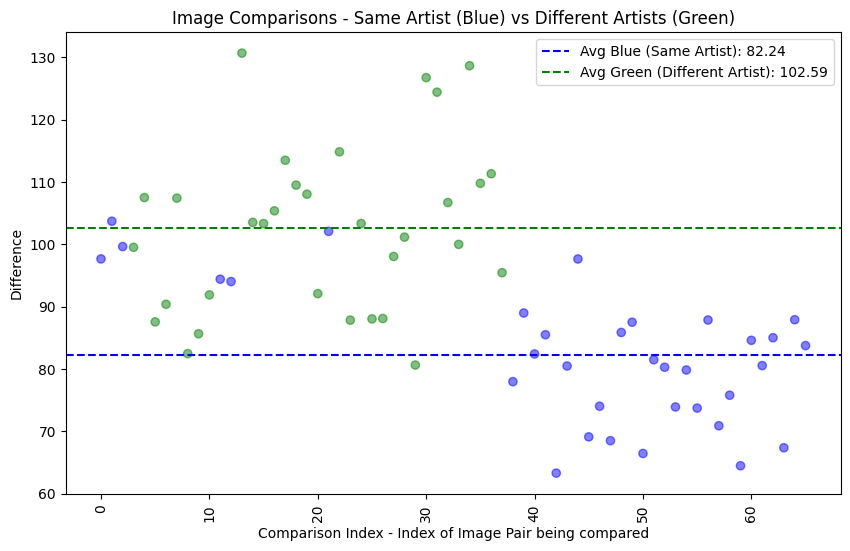

Average value for blue dots (Same Artist): 82.24496245916002
Average value for red dots (Different Artists): 102.59346167459006


In [122]:
two_artist_total_comparisons, highest_sim_two_artist_total, lowest_sim_two_artist_total = final_calculate_total_image_comparisons(both_artist_image_descriptions, "bert")

print("Most Dissimilar:", highest_sim_two_artist_total)
print("Most Similar:", lowest_sim_two_artist_total)

visualize_comparisons_two_artists(label_change_artist(two_artist_total_comparisons, both_artist_images))

Most Dissimilar: ('Putti, detail from The Sistine Madonna', 'The Two Fridas')
Most Similar: ('What the Water Gave Me', 'The Dream (The Bed)')


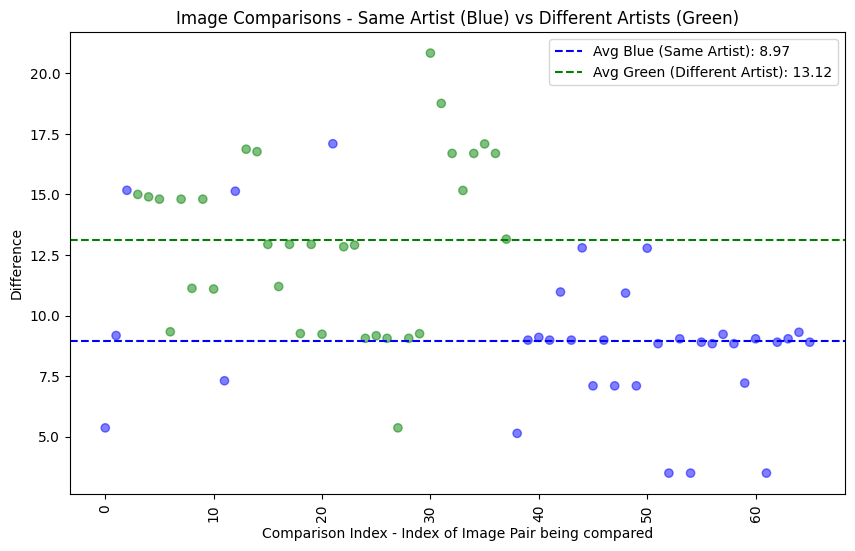

Average value for blue dots (Same Artist): 8.96533093866863
Average value for red dots (Different Artists): 13.117973977013117


In [124]:
two_artist_label_comparisons, highest_sim_two_artist_label, lowest_sim_two_artist_label = final_calculate_label_comparisons(both_artist_image_descriptions, "Style/Aesthetic", "bert")

print("Most Dissimilar:", highest_sim_two_artist_label)
print("Most Similar:", lowest_sim_two_artist_label)

visualize_comparisons_two_artists(label_change_artist(two_artist_label_comparisons, both_artist_images))

### Conclusion - Above Graph provides more domain-specific evidence supporting the efficacy of our model in quantifying images using our similarity function. It underscores the utility of our embeddings in generating tangible results.

## END: Comparing Images between Different Artists

####

## START: Comparing Images within a Diverse Subset of Art

In [64]:
def get_diverse_images(n):
    
    base_url = "https://www.wikiart.org/en/App/Painting/MostViewedPaintings"

    # Define the parameters for the API request
    params = {
        "json": 2,
    }

    # Send a GET request to the WikiArt API
    response = requests.get(base_url, params=params)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Shuffle the list of paintings and select the first n paintings
        random.shuffle(data)
        selected_paintings = data[:n]

        # URLs and years
        image_info = {}

        # Extract image URLs and years of selected paintings
        for painting in selected_paintings:
            if is_url_valid(painting["image"]):
                image_info[painting["title"]] = {"url": painting["image"], "year": painting["completitionYear"]}

        return image_info

    else:
        print(f"Failed to get data from WikiArt API: {response.status_code}")
        return None

In [90]:
# fetching and printing the diverse set of images

diverse_images = get_diverse_images(10)

if diverse_images:
    print(f"Found {len(diverse_images)} diverse images:")
    for name, url in diverse_images.items():
        print(f"{name}: {url}")

Found 10 diverse images:
Metamorphosis III: {'url': 'https://uploads6.wikiart.org/images/m-c-escher/metamorphosis-iii-1968-1.jpg!Large.jpg', 'year': 1968}
History of the Black People: {'url': 'https://uploads1.wikiart.org/images/jean-michel-basquiat/history-of-the-black-people.jpg!Large.jpg', 'year': 1983}
The old fisherman: {'url': 'https://uploads7.wikiart.org/images/pablo-picasso/the-old-fisherman-1895.jpg!Large.jpg', 'year': 1895}
Woman Grinding Maize: {'url': 'https://uploads0.wikiart.org/images/diego-rivera/woman-grinding-maize-1924.jpg!Large.jpg', 'year': 1924}
Spirit Of Spring: {'url': 'https://uploads7.wikiart.org/images/alphonse-mucha/spirit-of-spring-1894.jpg!Large.jpg', 'year': 1894}
Nestlé`s Food for Infants: {'url': 'https://uploads7.wikiart.org/images/alphonse-mucha/nestlé-s-food-for-infants-1897.jpg!Large.jpg', 'year': 1897}
Lorenzaccio: {'url': 'https://uploads2.wikiart.org/images/alphonse-mucha/lorenzaccio-1896.jpg!Large.jpg', 'year': 1896}
Ascension: {'url': 'https:/

In [100]:
print(diverse_images)

{'Metamorphosis III': {'url': 'https://uploads6.wikiart.org/images/m-c-escher/metamorphosis-iii-1968-1.jpg!Large.jpg', 'year': 1968}, 'History of the Black People': {'url': 'https://uploads1.wikiart.org/images/jean-michel-basquiat/history-of-the-black-people.jpg!Large.jpg', 'year': 1983}, 'The old fisherman': {'url': 'https://uploads7.wikiart.org/images/pablo-picasso/the-old-fisherman-1895.jpg!Large.jpg', 'year': 1895}, 'Woman Grinding Maize': {'url': 'https://uploads0.wikiart.org/images/diego-rivera/woman-grinding-maize-1924.jpg!Large.jpg', 'year': 1924}, 'Spirit Of Spring': {'url': 'https://uploads7.wikiart.org/images/alphonse-mucha/spirit-of-spring-1894.jpg!Large.jpg', 'year': 1894}, 'Nestlé`s Food for Infants': {'url': 'https://uploads7.wikiart.org/images/alphonse-mucha/nestlé-s-food-for-infants-1897.jpg!Large.jpg', 'year': 1897}, 'Lorenzaccio': {'url': 'https://uploads2.wikiart.org/images/alphonse-mucha/lorenzaccio-1896.jpg!Large.jpg', 'year': 1896}, 'Ascension': {'url': 'https://

In [91]:
diverse_images_descriptions = final_get_image_description_labels(diverse_images)

Image Processed:  1
Image Processed:  2
Image Processed:  3
Image Processed:  4
Image Processed:  5
Image Processed:  6
Image Processed:  7
Image Processed:  8
Image Processed:  9
Image Processed:  10


In [92]:
def label_change_index(comparisons, images):

    index_comparisons = []

    for comparison in comparisons:
        # Separate the first image name and the second image name
        image1, image2 = comparison[0].split(' vs ')
        
        # Extract the indices corresponding to the images
        index1 = list(images.keys()).index(image1) + 1
        index2 = list(images.keys()).index(image2) + 1
        
        # Create a new key with the indices instead of image names
        new_key = f"{index1} vs {index2}"
        index_comparisons.append((new_key, comparison[1]))

    return index_comparisons

### *USER INTERACTION

In [99]:
# Default : Total Comparison using BERT

diverse_images_comparisons, highest_sim_diverse, lowest_sim_diverse = final_calculate_total_image_comparisons(diverse_images_descriptions, "bert")

# USER MODIFICATION

# Try out different attributes to compare images.
# Try out different similarity metrics to compare images.

# Uncomment line below to run custom comparison.

#diverse_images_comparisons, highest_sim_diverse, lowest_sim_diverse = final_calculate_label_comparisons(diverse_images_descriptions, "Color Palette", "bert")

print("Most dissimilar images:", highest_sim_diverse)
print("Most similar images:", lowest_sim_diverse)

Most dissimilar images: ('History of the Black People', 'Spirit Of Spring')
Most similar images: ('The old fisherman', 'Irises')


### * OPTIONAL VISUALIZATION

In [115]:
def visualize_comparisons_diverse(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Find the index of the maximum and minimum differences
    max_diff_index = np.argmax(differences)
    min_diff_index = np.argmin(differences)

    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(differences)), differences, c='blue', alpha=0.5)

    # Annotate points with image comparison labels
    for i, (pair, diff) in enumerate(zip(image_pairs, differences)):
        plt.annotate(pair, (i, diff), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=6)

    # Plot vertical lines for maximum and minimum differences
    plt.axvline(x=max_diff_index, color='red', linestyle='--', label=f'Highest Difference')
    plt.axvline(x=min_diff_index, color='green', linestyle='--', label=f'Lowest Difference')

    plt.legend()

    plt.title('Image Comparisons - Highest and Lowest Similarity Scores')
    plt.xlabel('Comparison Index')
    plt.ylabel('Difference')
    plt.xticks(rotation=90)
    plt.show()

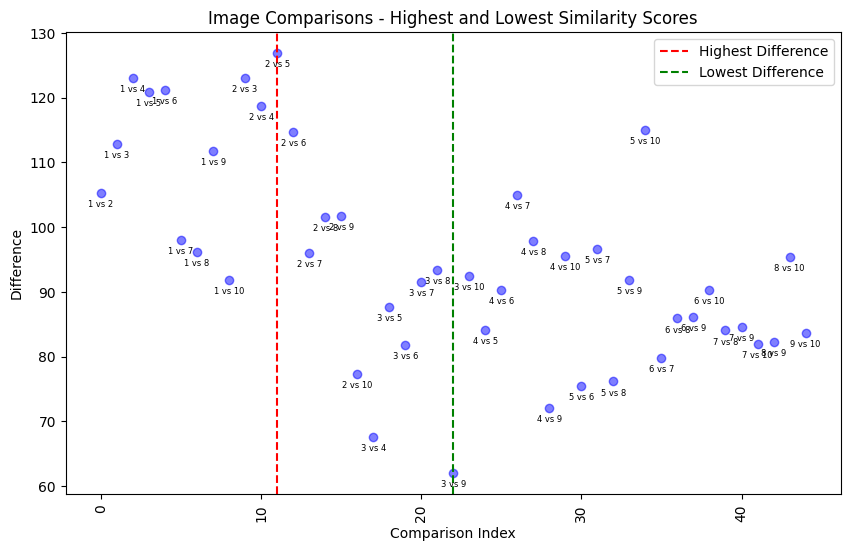

In [106]:
visualize_comparisons_diverse(label_change_index(diverse_images_comparisons, diverse_images))